In [ ]:
!wget https://raw.githubusercontent.com/angeltamang123/Nepali-Hate-Sentiment-Detection/refs/heads/main/Project/Part%202/Data/Preprocessed/Cleaned_Nepali_dataset.csv

--2025-01-19 11:42:54--  https://raw.githubusercontent.com/angeltamang123/Nepali-Hate-Sentiment-Detection/refs/heads/main/Project/Part%202/Data/Preprocessed/Cleaned_Nepali_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467029 (456K) [text/plain]
Saving to: ‘Cleaned_Nepali_dataset.csv’

Cleaned_Nepali_data 100%[===================>] 456.08K  --.-KB/s    in 0.05s   

2025-01-19 11:42:54 (9.80 MB/s) - ‘Cleaned_Nepali_dataset.csv’ saved [467029/467029]



In [ ]:
import pandas as pd
import numpy as np

filepath= "/content/Cleaned_Nepali_dataset.csv"
df= pd.read_csv(filepath)

# Setting up torch
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Setting default device to what's available
torch.set_default_device(device)

# The embeddings from SONAR
X_train_sonar= torch.load('X_train_embeddings.pt')
X_test_sonar= torch.load('X_test_embeddings.pt')
y_train_sonar= torch.load('y_train_tensor.pt')
y_test_sonar= torch.load('y_test_tensor.pt')

# Shape verification
print("X_train shape", X_train_sonar.shape)
print("X_test shape", X_test_sonar.shape)
print("y_train shape", y_train_sonar.shape)
print("y_test shape", y_test_sonar.shape)

Using cpu device
X_train shape torch.Size([2287, 1024])
X_test shape torch.Size([572, 1024])
y_train shape torch.Size([2287])
y_test shape torch.Size([572])


<ipython-input-2-211bdaec97df>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train_sonar= torch.load('X_train_embeddings.pt')
<ipython-input-2-211bdaec97df>:24: Future

In [ ]:
# Convert y_train_sonar and y_test_sonar to NumPy
y_train_np = y_train_sonar.cpu().numpy()
y_test_np = y_test_sonar.cpu().numpy()

# Create DataFrames
df_train = pd.DataFrame({'Original_Target': y_train_np})
df_test = pd.DataFrame({'Original_Target': y_test_np})

df_train.head()

,Original_Target
0,1
1,1
2,0
3,2
4,1


In [ ]:
# Function maps both polarity of GENERAL, PROFANITY and VIOLENCE to single representation
def map_target(value):
    if value in [0, 1]:
        return 0 # GENERAL
    elif value in [2, 3]:
        return 1 # PROFANITY
    elif value in [4, 5]:
        return 2 # VOILENCE

# Mapping
df_train['Mapped_Target'] = df_train['Original_Target'].apply(map_target)
df_test['Mapped_Target'] = df_test['Original_Target'].apply(map_target)

df_train.head()


,Original_Target,Mapped_Target
0,1,0
1,1,0
2,0,0
3,2,1
4,1,0


In [ ]:
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

# Using new mapping
y_train_sonar_mapped = torch.tensor(df_train['Mapped_Target'].values, dtype=torch.long, device=device)
y_test_sonar_mapped = torch.tensor(df_test['Mapped_Target'].values, dtype=torch.long, device=device)

# Combine embeddings and labels into TensorDataset
train_dataset = TensorDataset(X_train_sonar, y_train_sonar_mapped)
test_dataset = TensorDataset(X_test_sonar, y_test_sonar_mapped)

# Concatenating train and test dataset
dataset = ConcatDataset([train_dataset, test_dataset])

dataset[0]

(tensor([ 0.0057, -0.0019, -0.0025,  ...,  0.0020, -0.0027, -0.0029]),
 tensor(0))

In [ ]:
# Retrieving tensors of PROFANITY class i.e 1

profanity_set= [
    (x, y) for x, y in dataset if y.item() == 1
]

print(f"Number of instances with target 1: {len(profanity_set)}")
for i, (x, y) in enumerate(profanity_set[:5]):  # Show first 5 instances
    print(f"Instance {i}: X = {x}, Target = {y}")

Number of instances with target 1: 333
Instance 0: X = tensor([-0.0039,  0.0003, -0.0044,  ..., -0.0010, -0.0041, -0.0005]), Target = 1
Instance 1: X = tensor([-0.0003,  0.0005, -0.0022,  ..., -0.0005,  0.0042,  0.0021]), Target = 1
Instance 2: X = tensor([-0.0056, -0.0024, -0.0021,  ...,  0.0066,  0.0077, -0.0015]), Target = 1
Instance 3: X = tensor([ 0.0023,  0.0098, -0.0007,  ...,  0.0010,  0.0045, -0.0010]), Target = 1
Instance 4: X = tensor([ 0.0031, -0.0055,  0.0083,  ...,  0.0054, -0.0004,  0.0033]), Target = 1


In [ ]:
# Profanity does contain 333 instance --> Saving to build an individual profanity classifier

torch.save(profanity_set, "profanity_set.pt")


In [ ]:
# Now we continue building with our dataset

# Defining Network
import torch.nn as nn
import torch.optim as optim

# Defining neural network
class Sonar_Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation=nn.ReLU, dropout= 0.5):
        super(Sonar_Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialization
input_dim = 1024       # Dimension of SONAR embeddings
hidden_dim = 128       # Number of hidden units(Hyperparameter)
output_dim = len(set(y_train_sonar_mapped.numpy()))  # Number of unique classes

model = Sonar_Classifier(input_dim, hidden_dim, output_dim) # model with default architecture
model.to(device= device) # Train model in what's available
print(model)

Sonar_Classifier(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
# Weights for loss function
from sklearn.utils.class_weight import compute_class_weight

# Getting Class Weights
y_train_mapped_np = y_train_sonar_mapped.numpy()

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Automatically balances based on class frequencies
    classes=np.unique(y_train_mapped_np),  # Unique classes in training labels
    y=y_train_mapped_np  # Training labels
)
class_weights = class_weights / np.sum(class_weights) # Normalizing magnitude for proper gradient updates

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Normalized Class Weights:", class_weights_tensor)

Normalized Class Weights: tensor([0.0617, 0.4222, 0.5161])


In [ ]:
# loss function and Adam Optimizer
criterion = nn.CrossEntropyLoss(weight= class_weights_tensor)  # For multi-class classification(class weight passaable)
optimizer = optim.Adam(model.parameters(), lr=0.05)  # Adam optimizer

In [ ]:
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Batch size adjustable
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Initialize the learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def model_train(model, criterion, optimizer, train_loader, test_loader, epochs=20):
  # Initialize lists to store training and testing losses
  train_losses = []
  test_losses = []

  # Training and evaluation loop
  for epoch in range(epochs):
      # Training phase
      model.train()
      train_loss = 0
      for X_batch, y_batch in train_loader:
          optimizer.zero_grad()
          outputs = model(X_batch)
          loss = criterion(outputs, y_batch.long())  # Ensure labels are long type
          loss.backward()
          # Prevent exploading gradients by clipping
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          train_loss += loss.item()
      train_loss /= len(train_loader)  # Average loss for training
      train_losses.append(train_loss)

      # Testing phase
      model.eval()
      test_loss = 0
      with torch.no_grad():
          for X_batch, y_batch in test_loader:
              outputs = model(X_batch)
              loss = criterion(outputs, y_batch.long())
              test_loss += loss.item()
      test_loss /= len(test_loader)  # Average loss for testing
      test_losses.append(test_loss)

      # # Update learning rate based on test loss
      # scheduler.step(test_loss)

      # Print losses for the epoch
      print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

  # Plot the learning curve
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
  plt.plot(range(1, epochs+1), test_losses, label='Testing Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Learning Curve')
  plt.legend()
  plt.grid()
  plt.show()


Epoch 1/20, Train Loss: 1.0884, Test Loss: 1.0562
Epoch 2/20, Train Loss: 1.0227, Test Loss: 0.9795
Epoch 3/20, Train Loss: 0.9489, Test Loss: 0.9351
Epoch 4/20, Train Loss: 0.9867, Test Loss: 0.9409
Epoch 5/20, Train Loss: 0.9294, Test Loss: 0.9971
Epoch 6/20, Train Loss: 0.8710, Test Loss: 0.9852
Epoch 7/20, Train Loss: 0.8787, Test Loss: 0.9532
Epoch 8/20, Train Loss: 0.8873, Test Loss: 1.0796
Epoch 9/20, Train Loss: 0.8551, Test Loss: 0.9908
Epoch 10/20, Train Loss: 0.8264, Test Loss: 1.0120
Epoch 11/20, Train Loss: 0.8360, Test Loss: 0.9327
Epoch 12/20, Train Loss: 0.8141, Test Loss: 1.1197
Epoch 13/20, Train Loss: 0.8319, Test Loss: 1.0190
Epoch 14/20, Train Loss: 0.8143, Test Loss: 1.0579
Epoch 15/20, Train Loss: 0.7819, Test Loss: 1.1452
Epoch 16/20, Train Loss: 0.8001, Test Loss: 1.1714
Epoch 17/20, Train Loss: 0.7683, Test Loss: 1.2307
Epoch 18/20, Train Loss: 0.7949, Test Loss: 1.2085
Epoch 19/20, Train Loss: 0.7996, Test Loss: 1.1897
Epoch 20/20, Train Loss: 0.7953, Test Lo

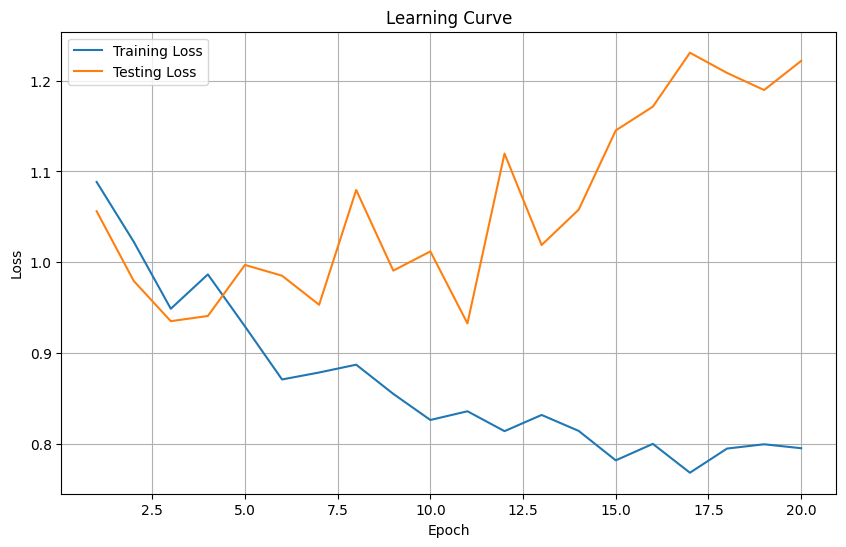

In [ ]:
model_train(model, criterion, optimizer, train_loader, test_loader)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.82       452
           1       0.21      0.22      0.21        69
           2       0.24      0.43      0.31        51

    accuracy                           0.69       572
   macro avg       0.44      0.48      0.45       572
weighted avg       0.73      0.69      0.70       572



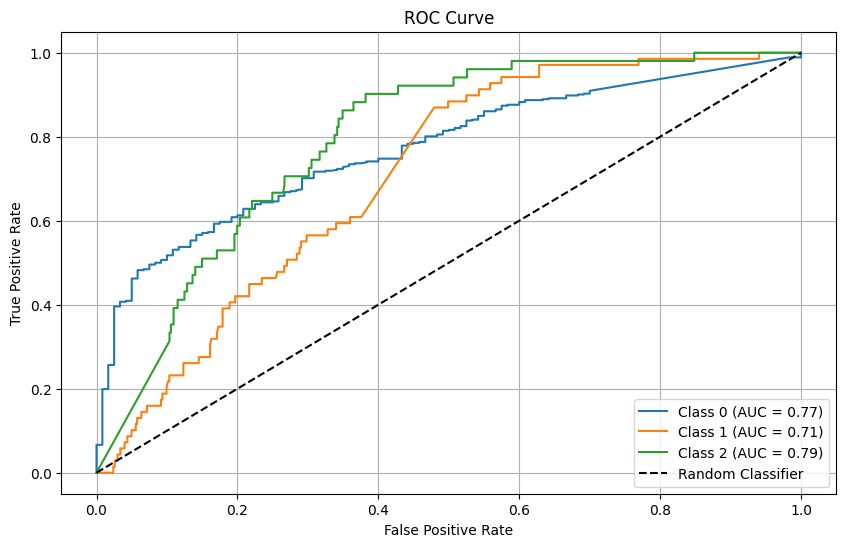

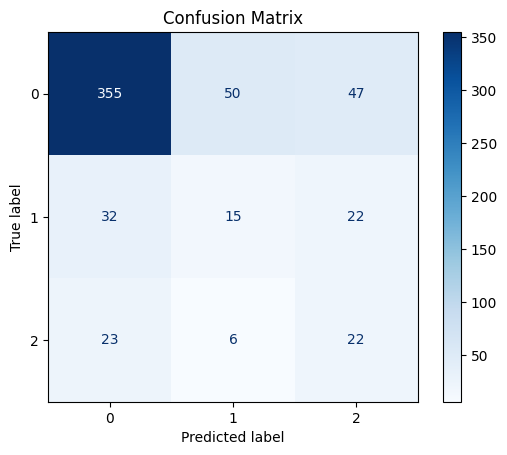

In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set, generate a classification report, plot the ROC curve,
    and display the confusion matrix.

    Parameters:
        model: Trained PyTorch model
        test_loader: DataLoader for the test set

    Returns:
        None
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Model predictions
            probs = torch.softmax(outputs, dim=1)  # Convert to probabilities
            preds = torch.argmax(probs, dim=1)  # Predicted classes

            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Determine the number of classes
    num_classes = all_probs.shape[1]

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # ROC Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(model, test_loader)

In [ ]:
!pip install ray[tune]
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune, train
from ray.tune.schedulers import ASHAScheduler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from ray.tune.search.optuna import OptunaSearch


# Define model class
class Sonar_Classifier_hyperparameters(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation=nn.ReLU, dropout=0.5):
        super(Sonar_Classifier_hyperparameters, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training function for Ray Tune
def train_model(config):
    # Ensure the device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load data (make sure the data is on the correct device)
    train_dataset = TensorDataset(X_train_sonar, y_train_sonar_mapped)
    test_dataset = TensorDataset(X_test_sonar, y_test_sonar_mapped)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)


    # Map activation, retriving from string as searching module directly can clutter logs
    activation_map = {
        "ReLU": nn.ReLU,
        "Tanh": nn.Tanh,
        "LeakyReLU": nn.LeakyReLU
        }

    activation = activation_map[config["activation"]]

    # Initialize model and move it to the correct device
    model = Sonar_Classifier_hyperparameters(
        input_dim=1024,
        hidden_dim=config["hidden_dim"],
        output_dim=len(set(y_train_sonar_mapped.numpy())),
        activation=activation,
        dropout=config["dropout"]
    )
    print(model)
    model.to(device)

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train_mapped_np),
        y=y_train_mapped_np
    )
    class_weights = class_weights / np.sum(class_weights)  # Normalizing magnitude for proper gradient updates

    # Convert class weights to a PyTorch tensor
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = getattr(optim, config["optimizer"])(model.parameters(), lr=config["lr"])

    # Training loop
    for epoch in range(config["epochs"]):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.long())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        test_loss = 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.long())
                test_loss += loss.item()
                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

        # Compute F1 Score
        f1 = f1_score(y_true, y_pred, average="macro")

        # Send results to Ray Tune
        train.report({"f1": f1})


# Define search space
search_space = {
    "batch_size": tune.choice([4, 8, 16, 32, 64]),
    "hidden_dim": tune.lograndint(64, 512),
    "optimizer": tune.choice(["Adam", "SGD", "AdamW", "Adagrad", "NAdam", "Adamax"]),
    "lr": tune.loguniform(1e-5, 1e-2),
    "epochs": tune.randint(50,500),
    "activation": tune.choice(["ReLU", "Tanh", "LeakyReLU"]),
    "dropout": tune.uniform(0.2, 0.5),
}

# Using GPU
trainable_with_resources = tune.with_resources(train_model,
                                               resources={
                                                   "cpu": 2,
                                                   "gpu": 1 if torch.cuda.is_available() else 0
                                               }
                                               )

# Set up the OptunaSearch algorithm
optuna_search = OptunaSearch(metric="f1", mode="max")

# Configure Ray Tune
scheduler = ASHAScheduler(metric="f1", mode="max", max_t=200, grace_period=30)
tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(
        search_alg=optuna_search,
        scheduler=scheduler,
        num_samples=50,
    ),
    param_space=search_space,
)

results = tuner.fit()




2025-01-18 07:58:41,700	INFO worker.py:1821 -- Started a local Ray instance.
2025-01-18 07:58:44,591	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
[I 2025-01-18 07:58:45,250] A new study created in memory with name: optuna


+--------------------------------------------------------------------+
| Configuration for experiment     train_model_2025-01-18_07-58-37   |
+--------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                   |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 50                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_2025-01-18_07-58-37
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-01-18_07-58-37_804549_179/artifacts/2025-01-18_07-58-45/train_model_2025-01-18_07-58-37/driver_artifacts`

Trial status: 1 PENDING
Current time: 2025-01-18 07:58:46. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------

2025-01-18 08:44:42,520	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2025-01-18_07-58-37' in 0.0795s.



Trial train_model_44bcc1d3 completed after 30 iterations at 2025-01-18 08:44:42. Total running time: 45min 56s
+-----------------------------------------------+
| Trial train_model_44bcc1d3 result             |
+-----------------------------------------------+
| checkpoint_dir_name                           |
| time_this_iter_s                      0.20407 |
| time_total_s                          6.90872 |
| training_iteration                         30 |
| f1                                    0.29427 |
+-----------------------------------------------+

Trial status: 50 TERMINATED
Current time: 2025-01-18 08:44:42. Total running time: 45min 56s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name             status         batch_size     hidden_dim   optimizer              lr     epochs   activation       dr

In [ ]:
# Get the best result
best_config = results.get_best_result(metric="f1", mode="max")
print("Best hyperparameters:", best_config.config)

Best hyperparameters: {'batch_size': 64, 'hidden_dim': 222, 'optimizer': 'Adagrad', 'lr': 0.0030754135797064503, 'epochs': 415, 'activation': 'LeakyReLU', 'dropout': 0.41566778988985065}


In [ ]:
# Analyzing result

df= results.get_dataframe()
df.sort_values(by= "f1", ascending= False, inplace=True)

In [ ]:
df.head()

,f1,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,time_since_restore,iterations_since_restore,config/batch_size,config/hidden_dim,config/optimizer,config/lr,config/epochs,config/activation,config/dropout,logdir
43,0.493124,1737189463,None,True,30,e9a58594,2025-01-18_08-37-43,0.177552,7.333893,16945,...,7.333893,30,64,222,Adagrad,0.003075,415,LeakyReLU,0.415668,e9a58594
37,0.492626,1737189279,None,True,30,bfe5423f,2025-01-18_08-34-39,0.175472,6.586427,15784,...,6.586427,30,64,221,Adagrad,0.004729,447,LeakyReLU,0.341424,bfe5423f
44,0.491518,1737189479,None,True,30,f1fc12c1,2025-01-18_08-37-59,0.193104,6.874508,17090,...,6.874508,30,64,217,Adagrad,0.002384,413,LeakyReLU,0.416822,f1fc12c1
33,0.490044,1737189182,None,True,200,448da6e4,2025-01-18_08-33-02,0.144310,39.091803,14972,...,39.091803,200,64,163,Adagrad,0.004139,394,LeakyReLU,0.293706,448da6e4
36,0.489655,1737189264,None,True,30,ecb24a81,2025-01-18_08-34-24,0.173419,6.816843,15653,...,6.816843,30,64,223,Adagrad,0.006452,417,LeakyReLU,0.337143,ecb24a81


In [ ]:
model2= Sonar_Classifier(input_dim=1024, hidden_dim=222, output_dim=3, activation=nn.LeakyReLU, dropout=0.41566778988985065)
model2.to(device= device)
print(model2)

Sonar_Classifier(
  (fc1): Linear(in_features=1024, out_features=222, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.41566778988985065, inplace=False)
  (fc2): Linear(in_features=222, out_features=3, bias=True)
)


Epoch 1/91, Train Loss: 1.0951, Test Loss: 1.0903
Epoch 2/91, Train Loss: 1.0825, Test Loss: 1.0813
Epoch 3/91, Train Loss: 1.0697, Test Loss: 1.0709
Epoch 4/91, Train Loss: 1.0546, Test Loss: 1.0601
Epoch 5/91, Train Loss: 1.0380, Test Loss: 1.0496
Epoch 6/91, Train Loss: 1.0227, Test Loss: 1.0390
Epoch 7/91, Train Loss: 1.0094, Test Loss: 1.0297
Epoch 8/91, Train Loss: 0.9949, Test Loss: 1.0213
Epoch 9/91, Train Loss: 0.9789, Test Loss: 1.0130
Epoch 10/91, Train Loss: 0.9683, Test Loss: 1.0059
Epoch 11/91, Train Loss: 0.9555, Test Loss: 0.9986
Epoch 12/91, Train Loss: 0.9439, Test Loss: 0.9924
Epoch 13/91, Train Loss: 0.9352, Test Loss: 0.9864
Epoch 14/91, Train Loss: 0.9235, Test Loss: 0.9813
Epoch 15/91, Train Loss: 0.9142, Test Loss: 0.9765
Epoch 16/91, Train Loss: 0.9042, Test Loss: 0.9717
Epoch 17/91, Train Loss: 0.8992, Test Loss: 0.9674
Epoch 18/91, Train Loss: 0.8884, Test Loss: 0.9629
Epoch 19/91, Train Loss: 0.8823, Test Loss: 0.9591
Epoch 20/91, Train Loss: 0.8703, Test Lo

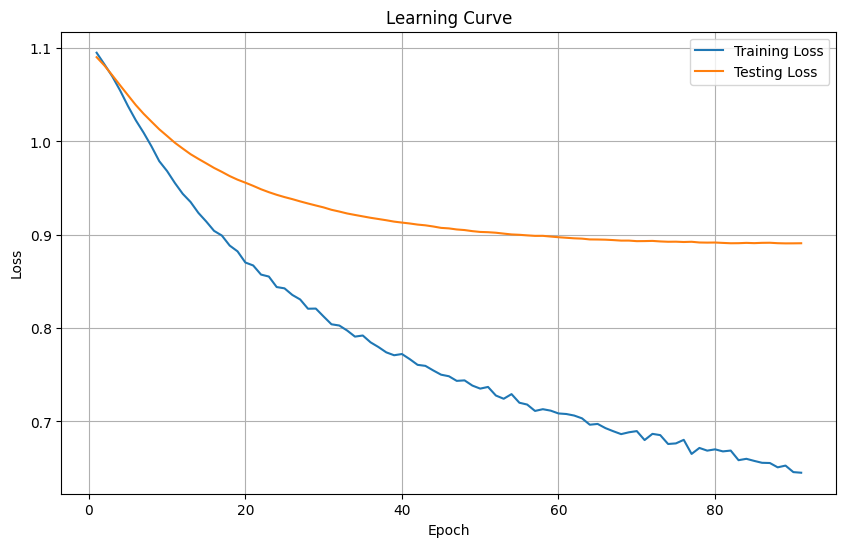

In [ ]:
criterion2= nn.CrossEntropyLoss(weight= class_weights_tensor)
optimizer2= optim.Adagrad(model2.parameters(), lr=0.0030754135797064503)
train_loader2 = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Batch size adjustable
test_loader2 = DataLoader(test_dataset, batch_size=64, shuffle=False)
epochs= 91
model_train(model=model2, criterion=criterion2, optimizer=optimizer2, train_loader=train_loader2, test_loader=test_loader2, epochs=epochs)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       452
           1       0.23      0.43      0.30        69
           2       0.28      0.53      0.37        51

    accuracy                           0.66       572
   macro avg       0.48      0.56      0.49       572
weighted avg       0.78      0.66      0.70       572



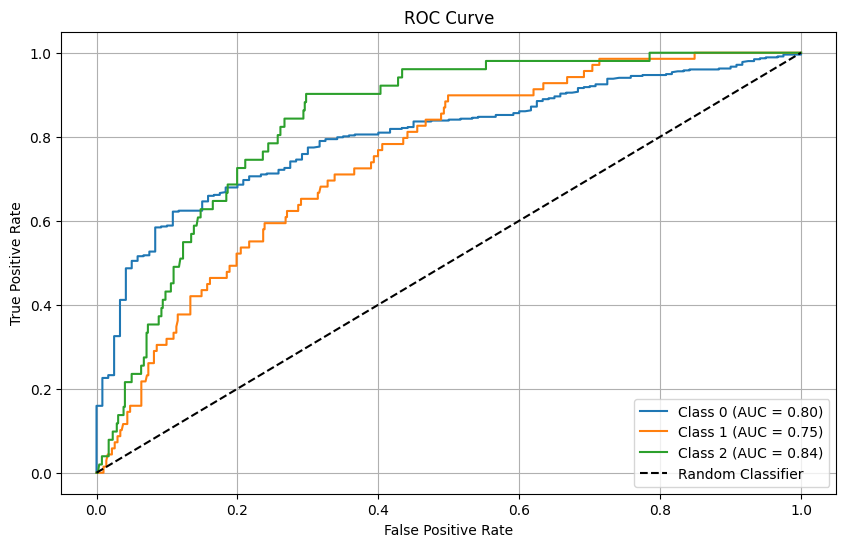

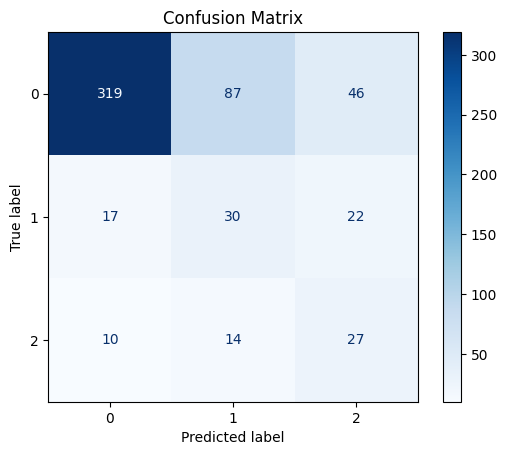

In [ ]:
evaluate_model(model2, test_loader2)

Fold 1
Training on 2287 samples and validating on 572 samples.
F1 Score: 0.5658
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       452
           1       0.32      0.60      0.42        67
           2       0.37      0.58      0.46        53

    accuracy                           0.71       572
   macro avg       0.54      0.64      0.57       572
weighted avg       0.80      0.71      0.74       572



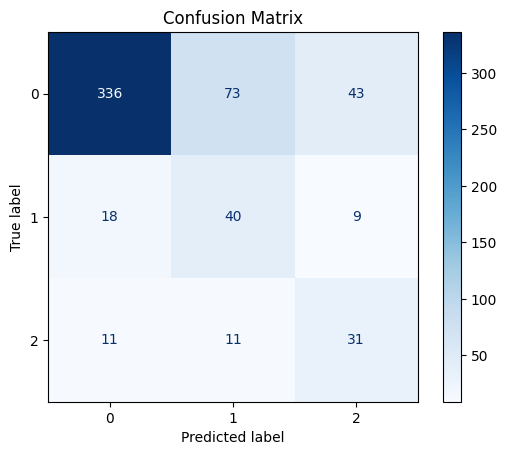

Fold 2
Training on 2287 samples and validating on 572 samples.
F1 Score: 0.5542
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83       452
           1       0.32      0.57      0.41        67
           2       0.33      0.58      0.42        53

    accuracy                           0.71       572
   macro avg       0.53      0.63      0.55       572
weighted avg       0.81      0.71      0.74       572



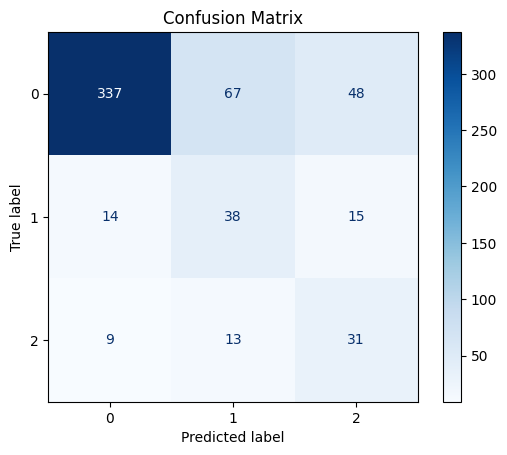

Fold 3
Training on 2287 samples and validating on 572 samples.
F1 Score: 0.5492
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       452
           1       0.29      0.56      0.38        66
           2       0.37      0.59      0.45        54

    accuracy                           0.70       572
   macro avg       0.53      0.63      0.55       572
weighted avg       0.80      0.70      0.73       572



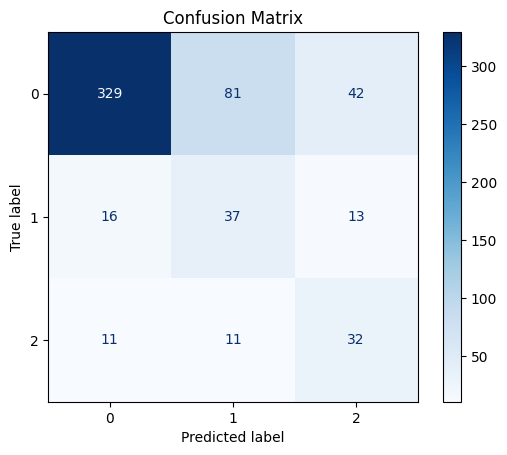

Fold 4
Training on 2287 samples and validating on 572 samples.
F1 Score: 0.5458
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.72      0.82       452
           1       0.27      0.56      0.37        66
           2       0.37      0.59      0.45        54

    accuracy                           0.69       572
   macro avg       0.53      0.63      0.55       572
weighted avg       0.80      0.69      0.73       572



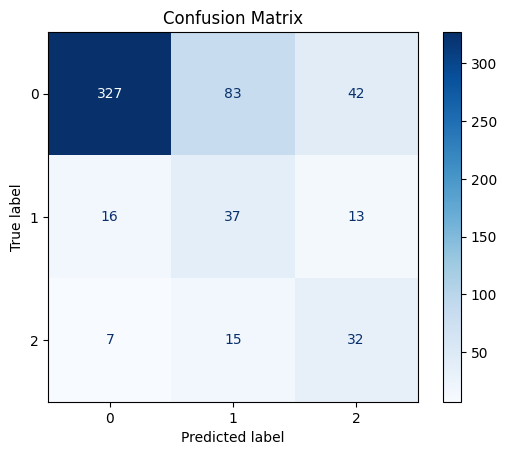

Fold 5
Training on 2288 samples and validating on 571 samples.
F1 Score: 0.4976
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       451
           1       0.28      0.52      0.36        67
           2       0.27      0.49      0.35        53

    accuracy                           0.65       571
   macro avg       0.48      0.57      0.50       571
weighted avg       0.77      0.65      0.69       571



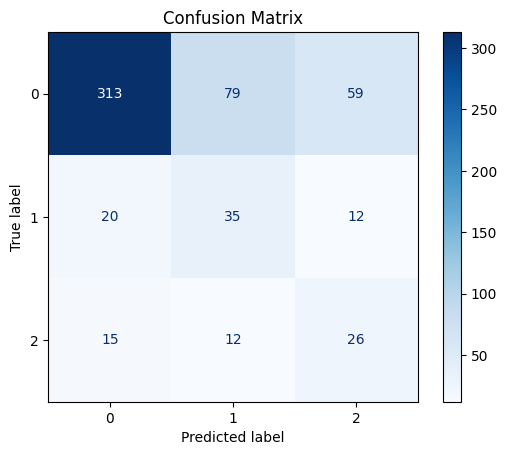

In [ ]:
# Doing stratified k-fold cross validation

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score

splits= 5
strat_kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

# Extract features and labels for stratification
features = torch.cat([d[0].unsqueeze(0) for d in dataset], dim=0)
labels = torch.cat([d[1].unsqueeze(0) for d in dataset], dim=0).numpy()

epochs_cv= 91
batch_size_cv= 64
for fold, (train_ids, val_ids) in enumerate(strat_kfold.split(features, labels)):
    print(f'Fold {fold + 1}')
    print(f'Training on {len(train_ids)} samples and validating on {len(val_ids)} samples.')

    # Subset the dataset for this fold
    train_subset = Subset(dataset, train_ids)
    val_subset = Subset(dataset, val_ids)

    # Create DataLoaders
    train_loader_cv = DataLoader(train_subset, batch_size=batch_size_cv, shuffle=True)
    val_loader_cv = DataLoader(val_subset, batch_size=batch_size_cv, shuffle=False)

    # Reinitialize the model
    model_cv = Sonar_Classifier(input_dim=1024, hidden_dim=222, output_dim=3, activation=nn.LeakyReLU, dropout=0.41566778988985065)
    model_cv = model_cv.to(device)

    # Reinitialize optimizer_cv and criterion_cv
    optimizer_cv = torch.optim.Adagrad(model_cv.parameters(), lr=0.0030754135797064503)
    criterion_cv = torch.nn.CrossEntropyLoss(weight= class_weights_tensor)

    # Training and validation loop
    for epoch in range(epochs_cv):

        # Training phase
        model_cv.train()
        for batch_features, batch_labels in train_loader_cv:
            # Move data to the appropriate device
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass, loss computation, and backpropagation
            optimizer_cv.zero_grad()
            outputs = model_cv(batch_features)
            loss = criterion_cv(outputs, batch_labels)
            loss.backward()
            optimizer_cv.step()

    # Validation phase
    model_cv.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_features, batch_labels in val_loader_cv:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model_cv(batch_features)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Calculate F1 Score and Classification Report
    f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"F1 Score: {f1:.4f}")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()


## Differential Evolutions
Initial population is obtianed through compute_class_weight's output

In [ ]:
print(len(class_weights_tensor))

3


In [ ]:
# Saving file's for checkpointing DE

from google.colab import drive
import pickle

drive.mount('/content/drive')
save_path = '/content/drive/My Drive/Nepali Hate Sentiment Detection/differential_evolution_checkpoint.pkl'

def callback_func(intermediate_result):
    # Save current state of the optimizer
    state = {
        "best_solution": intermediate_result.x,
        "best_value": intermediate_result.fun,
        "population": intermediate_result.population,
        "population_energies": intermediate_result.population_energies,
        "message": intermediate_result.message,
    }
    print(f'Weights: {intermediate_result.x}, f1: {intermediate_result.fun}')
    with open(save_path, "wb") as f:
        pickle.dump(state, f)
    print(f"Checkpoint saved to {save_path}")

Mounted at /content/drive


In [ ]:
# Defining Objective function

from scipy.optimize import differential_evolution
from sklearn.metrics import f1_score

f1_scores= []
# Function that DE minimizes
def objective_function(weights):
  weights = torch.tensor(weights, dtype=torch.float).to(device)
  model_de= Sonar_Classifier(input_dim=1024, hidden_dim=222, output_dim=3, activation=nn.LeakyReLU, dropout=0.41566778988985065)
  criterion_de = nn.CrossEntropyLoss(weight=weights)
  optimizer_de = optim.Adagrad(model_de.parameters(), lr=0.0030754135797064503)
  train_loader_de = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Batch size adjustable
  test_loader_de = DataLoader(test_dataset, batch_size=64, shuffle=False)
  epochs_de= 91

  for epoch in range(epochs_de):
    # Training
    model_de.train()
    for batch_features, batch_labels in train_loader_de:
      optimizer_de.zero_grad()
      outputs = model_de(batch_features)
      loss = criterion_de(outputs, batch_labels.long())
      loss.backward()
      # Prevent exploading gradients by clipping
      torch.nn.utils.clip_grad_norm_(model_de.parameters(), max_norm=1.0)
      optimizer_de.step()

    # Testing
    model_de.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for batch_features, batch_labels in test_loader_de:
        outputs = model_de(batch_features)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(batch_labels.numpy())

  # Calculate F1 Score
  f1 = f1_score(all_labels, all_preds, average="macro")
  f1_scores.append(f1)
  return -f1

In [ ]:
# Definingg parameters and Initilizing DE

# Number of classes
num_classes = len(class_weights_tensor)

# Bounds for each class
bounds = [(0, 1)] * num_classes

# Initial guess using compute_class_weight
initial_guess= class_weights_tensor.numpy()

# Population with  variations around the initial guess from compute_class_weight
population_size = 20 * num_classes
initial_population = np.random.uniform(0.5, 1.5, (population_size, num_classes)) * initial_guess

# Differential Evolution Run
result = differential_evolution(
    objective_function,
    bounds,
    init= initial_population, # inital population for DE
    disp= True,
    maxiter= 2000,
    tol= 1e-6,
    workers=-1,
    callback= callback_func
)

# optimal weights after DE run
optimal_weights= result.x


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= -0.5236443804758805
Weights: [0.07473441 0.29527582 0.50776223], f1: -0.5236443804758805
Checkpoint saved to /content/drive/My Drive/Nepali Hate Sentiment Detection/differential_evolution_checkpoint.pkl
differential_evolution step 2: f(x)= -0.5264172437869783
Weights: [0.07167806 0.30982225 0.50729895], f1: -0.5264172437869783
Checkpoint saved to /content/drive/My Drive/Nepali Hate Sentiment Detection/differential_evolution_checkpoint.pkl
differential_evolution step 3: f(x)= -0.5264172437869783
Weights: [0.07167806 0.30982225 0.50729895], f1: -0.5264172437869783
Checkpoint saved to /content/drive/My Drive/Nepali Hate Sentiment Detection/differential_evolution_checkpoint.pkl
differential_evolution step 4: f(x)= -0.5264172437869783
Weights: [0.07167806 0.30982225 0.50729895], f1: -0.5264172437869783
Checkpoint saved to /content/drive/My Drive/Nepali Hate Sentiment Detection/differential_evolution_checkpoint.pkl
differential_evolution step 5: f(x)= -0.

KeyboardInterrupt: 

In [ ]:
print(optimal_weights)
print(result.fun)
print("Termination Message:", result.message)
print("Number of Iterations:", result.nit)
print("Number of Function Evaluations:", result.nfev)

NameError: name 'optimal_weights' is not defined

In [ ]:
for i in range(0, len(f1_scores)):
  print(f"Iteration {i+1}: F1 Score = {f1_scores[i]:.4f}")

In [ ]:
# Checkpoint resume incase colab disconnects
from google.colab import drive
import pickle
import numpy as np
from scipy.optimize import differential_evolution

drive.mount('/content/drive')
save_path = '/content/drive/My Drive/Nepali Hate Sentiment Detection/differential_evolution_checkpoint.pkl'

# Load the checkpointed state
with open(save_path, 'rb') as f:
    state = pickle.load(f)

# Extract saved details from the checkpoint
best_solution = state['best_solution']
best_value = state['best_value']
population = state['population']
population_energies = state['population_energies']

print(f"Resuming from best solution: {best_solution} with best objective value: {best_value}")

# Number of classes
num_classes = len(best_solution)

# Bounds for each class
bounds = [(0, 1)] * num_classes

# Differential Evolution Run with checkpoint
result_checkpoint = differential_evolution(
    objective_function,
    bounds,
    init=population,  # Resume from saved population and energies
    disp=True,
    maxiter=2000,
    tol=1e-6,
    workers=-1,
    callback=callback_func
)

# Print final result
print("Optimization Complete")
print(f"Best solution: {result_checkpoint.x}")
print(f"Best objective value: {result_checkpoint.fun}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Resuming from best solution: [0.08204106 0.35654539 0.57071126] with best objective value: -0.5308189206514099
differential_evolution step 1: f(x)= -0.5324785567549785
Weights: [0.09288048 0.41031884 0.6440335 ], f1: -0.5324785567549785
Checkpoint saved to /content/drive/My Drive/Nepali Hate Sentiment Detection/differential_evolution_checkpoint.pkl
differential_evolution step 2: f(x)= -0.5324785567549785
Weights: [0.09288048 0.41031884 0.6440335 ], f1: -0.5324785567549785
Checkpoint saved to /content/drive/My Drive/Nepali Hate Sentiment Detection/differential_evolution_checkpoint.pkl
differential_evolution step 3: f(x)= -0.5324785567549785
Weights: [0.09288048 0.41031884 0.6440335 ], f1: -0.5324785567549785
Checkpoint saved to /content/drive/My Drive/Nepali Hate Sentiment Detection/differential_evolution_checkpoint.pkl
differential_evolution step 4: f(x)= -0.